In [1]:
# This notebook is for testing segments of code that requires more complex testing

# Imports

In [2]:
import sys
sys.path.append("../lib")

In [3]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm



In [4]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [5]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [6]:
from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import SimulationBatch

from analytics.batch import *
from analytics.student_stats import StudentStatCalc
from analytics.featurization import *
from analytics.cae import *

from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper


In [7]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [8]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.cae:Base directory for the project:
/rdata/Sandbox/MotivSim


In [9]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.cae:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-444394ac-9c66-4d8e-951e-c735624b7efe
INFO:analytics.cae:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [10]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 69 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 0 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 200 documents
INFO:log_db.mongo:collection name, units, has 2 documents
INFO:log_db.mongo:collection name, decisions, has 12651 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 8339 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 0 documents
INFO:log_db.mongo:collection name, problems, has 2044 documents
INFO:log_db.mongo:collection name, actions, has 12651 documents
INFO:log_db.mongo:collection name, sections, has 9 documents
INFO:log_db.mongo:collection name, tutor_events, has 11584 documents


# 1. Test Ability KC Learner

In [11]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.cae:Clearing database before starting new simulation
INFO:log_db.mongo:Clearing all documents from collection kcs
INFO:log_db.mongo:Clearing all documents from collection caa_batches
INFO:log_db.mongo:Clearing all documents from collection simbatches
INFO:log_db.mongo:Clearing all documents from collection caa_models
INFO:log_db.mongo:Clearing all documents from collection domains
INFO:log_db.mongo:Clearing all documents from collection students
INFO:log_db.mongo:Clearing all documents from collection units
INFO:log_db.mongo:Clearing all documents from collection decisions
INFO:log_db.mongo:Clearing all documents from collection curriculums
INFO:log_db.mongo:Clearing all documents from collection steps
INFO:log_db.mongo:Clearing all documents from collection finalsimstudents
INFO:log_db.mongo:Clearing all documents from collection problems
INFO:log_db.mongo:Clearing all documents from collection actions
INFO:log_db.mongo:Clearing all documents from collection sections
IN

## Simulating learners

### Helpers

In [12]:


def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(domain, curric, students, batch):    
    for i, stu in enumerate(students):
        logger.info("Simulating student #%i" % i)
        sim = ModLearnerSimulation(domain, curric, stu)
        batch.add_sim(sim)
        sim.run()
        
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [13]:
new_curric = None
new_domain = None

In [14]:
def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        domain_params = {'m_l0': 0.45,
                         'sd_l0': 0.155,
                         'm_l0_sd': 0.1,
                         'sd_l0_sd': 0.03,
                         'm_t': 0.1,
                         'sd_t': 0.05,
                         'm_s': 0.155,
                         'sd_s': 0.055,
                         'm_g': 0.15,#0.6,
                         'sd_g': 0.105
                        }
        curric_params = {'num_units': 2,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

### Simulating Students

In [15]:
num_students = 20

In [16]:
sim_batch_desc = "Test Bias Skill Cognition Learners"
cog_mod = BiasSkillCognition
dec_mod = DomainTunerDecider
def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {}

In [17]:
simbatch = db.simbatches.find_one({"desc": sim_batch_desc})
if simbatch is None:
    logger.info("Generating new simulation. None found in db")

    # generate simualted data for test
    domain, curric = gen_test_curric(db, db_params)
    students = gen_students(num_students, domain, curric, 
                            cog_mod, get_cog_params, 
                            dec_mod, get_dec_params) 
    logger.info(f"Persisting {len(students)} initialized students to db")
    db.students.insert_many([stu.to_dict() for stu in students])
    batch = SimulationBatch(sim_batch_desc)
    simulate_students(domain, curric, students, batch)    
    logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
else:
    logger.info(f"Found simulation batch: {str(simbatch)}")
    lmapper = DBLearnerMapper(db)
    students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
    batch = SimulationBatch.from_dict(simbatch)
    logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")


INFO:analytics.cae:Generating new simulation. None found in db
INFO:analytics.cae:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 2 units with with a total of 62 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, 34460589-aee9-407f-8cc2-2f0d4c935bbd, to db
INFO:log_db.curriculum_mapper:Writing 1826 problem to db
INFO:log_db.curriculum_mapper:Writing 7348 steps to db
INFO:analytics.cae:Persisting 20 initialized students to db
INFO:analytics.cae:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:analytics.cae:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:analytics.cae:Si

## EDA of simulated Data

### Helper Functions

In [33]:
def get_tx_fields(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    return tx.loc[:, ["_id", 'stu_id', 'kc', 'unit_id', 'section_id', 'prob_id', 'step_id', "duration"]]

In [18]:
def get_stu_parameters(sids, db, mastery_thres):
        presim_students = pd.DataFrame(db.students.find({"_id": {'$in':  sids}}))
        sim_students = pd.DataFrame(db.finalsimstudents.find({"_id": {'$in':  sids}}))
        sim_students.rename(columns={'skills': 'final skills',
                                     'total_attempts': 'final total attempts',
                                     'total_success': 'final total success'}, inplace=True)
        logger.debug("pre-sim students: %s" % str(presim_students.shape))
        logger.debug("post-sim students: %s" % str(sim_students.shape))

        sim_students = presim_students.merge(sim_students[['_id', 'final skills', 'final total attempts', 'final total success']], how='right', on=['_id'])
        sim_students['pre-sim total mastery'] = sim_students.apply(lambda x: np.sum([1 if d >= mastery_thres else 0 for d in list(x['skills'].values())]), axis=1)
        sim_students['final-sim total mastery'] = sim_students.apply(lambda x: np.sum([1 if d >= mastery_thres else 0 for d in list(x['final skills'].values())]), axis=1)
        sim_students['total skills'] = sim_students.apply(lambda x: len(list(x['skills'].values())), axis=1)
        sim_students['pre-sim pct mastery'] = sim_students.apply(lambda x: x['pre-sim total mastery'] / x['total skills'], axis=1)
        sim_students['final-sim pct mastery'] = sim_students.apply(lambda x: x['final-sim total mastery'] / x['total skills'], axis=1)
        sim_students['final-sim total unmastered'] = sim_students.apply(lambda x: x['total skills'] - x['final-sim total mastery'], axis=1)
        sim_students['pct success'] = sim_students.apply(lambda x: x['final total success'] / x['final total attempts'], axis=1)

        sim_students['values'] = sim_students.apply(lambda x: x['decider']['values'], axis=1)
        sim_students['diligence'] = sim_students.apply(lambda x: x['decider']['diligence'], axis=1)
        sim_students['cog_ability'] = sim_students.apply(lambda x: x['cog']['ability'], axis=1)
        sim_students.index = sim_students['_id']
        sim_students.drop(['_id'], axis=1, inplace=True)
        return sim_students

In [19]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_desc = ["Test Bias Skill Cognition Learners"]
sids_dict = {desc: [] for desc in batch_desc}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_desc:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids_dict[batch['desc']].append(batch['student_ids'])

INFO:analytics.cae:batch #0: 
ID: bf89915b-035c-4ad2-8a30-908ae34bcfba
desc: Test Bias Skill Cognition Learners
INFO:analytics.cae:recovered 20 student ids for batch Test Bias Skill Cognition Learners


#### Student Parameters

In [20]:
sids = sids_dict[batch_desc[0]][0]

In [21]:
calc = StudentStatCalc(db)
batch_calc = BatchCalculator()

In [22]:
mastery_thres = 0.9
args = [get_stu_parameters, sids, 10, [db, mastery_thres]]
sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student params: (20, 30)	Runtime: 0.058311 seconds


In [23]:
args = [calc.action_stats, sids, 10]
action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student action stats: (20, 9)	Runtime: 2.366701 seconds


In [24]:
args = [calc.total_tx_stats, sids, 10]
tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student activity stats: (20, 9)	Runtime: 2.059044 seconds


In [25]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

INFO:analytics.cae:Merged new stats together: (20, 48)


In [26]:

sim_students.head()

,domain_id,type,skills,cog,decider,off_task,attempted,total_attempts,total_success,state_fields,...,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,pct success,values,diligence,cog_ability
_id,,,,,,,,,,,,,,,,,,,,,
01f95557-fc43-47af-86d2-6dc19168d42b,14867f05-5078-46e9-a964-796e2fed9a3a,ModularLearner,{'9eaca52b-a9be-402e-b60e-b2e7e93722a3': 0.040...,"{'ability': 0.5081414986134651, 'domain_id': '...","{'type': 'DomainTunerDecider', 'values': {'att...",False,False,0,0,"[off_task, attempted, total_attempts, total_su...",...,0,62,62,0.000000,1.0,0,0.411168,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.046148,0.508141
2b65ed35-cc69-480b-99bd-3ff18f0dd435,14867f05-5078-46e9-a964-796e2fed9a3a,ModularLearner,{'9eaca52b-a9be-402e-b60e-b2e7e93722a3': 0.347...,"{'ability': -0.2385001382800338, 'domain_id': ...","{'type': 'DomainTunerDecider', 'values': {'att...",False,False,0,0,"[off_task, attempted, total_attempts, total_su...",...,1,62,62,0.016129,1.0,0,0.510372,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.041625,-0.238500
34444917-c6a6-4e90-b2d6-68fb2e17dda9,14867f05-5078-46e9-a964-796e2fed9a3a,ModularLearner,{'9eaca52b-a9be-402e-b60e-b2e7e93722a3': 0.280...,"{'ability': 0.07658434688220583, 'domain_id': ...","{'type': 'DomainTunerDecider', 'values': {'att...",False,False,0,0,"[off_task, attempted, total_attempts, total_su...",...,0,62,62,0.000000,1.0,0,0.501256,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.294587,0.076584
4b64866c-e0b2-4783-b4c5-b268648f2c63,14867f05-5078-46e9-a964-796e2fed9a3a,ModularLearner,{'9eaca52b-a9be-402e-b60e-b2e7e93722a3': 0.385...,"{'ability': 0.11174449024894562, 'domain_id': ...","{'type': 'DomainTunerDecider', 'values': {'att...",False,False,0,0,"[off_task, attempted, total_attempts, total_su...",...,0,62,62,0.000000,1.0,0,0.474401,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.151195,0.111744
621b004a-9b54-4962-b911-8b7aff1a49b1,14867f05-5078-46e9-a964-796e2fed9a3a,ModularLearner,{'9eaca52b-a9be-402e-b60e-b2e7e93722a3': 0.684...,"{'ability': -0.5987971007746173, 'domain_id': ...","{'type': 'DomainTunerDecider', 'values': {'att...",False,False,0,0,"[off_task, attempted, total_attempts, total_su...",...,2,62,62,0.032258,1.0,0,0.496633,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.224792,-0.598797


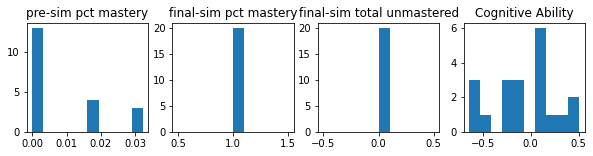

INFO:analytics.cae:Total skills: 62


In [27]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(142)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(143)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.subplot(144)
plt.hist(sim_students['cog_ability'], bins=10)
plt.title("Cognitive Ability")

plt.show()

logger.info("Total skills: %i" % sim_students['total skills'][0])


0: attempt
1: guess
2: hint request
3: off task


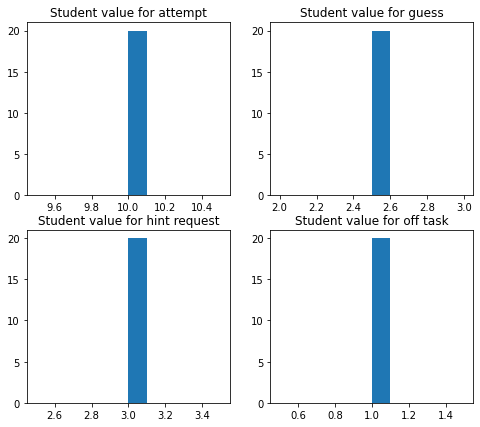

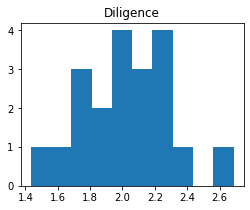

In [28]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Decisions EDA

In [29]:
# Get Learner decisions
if "stus_1" in globals():
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': [stu._id for stu in stus_1]}}))
else:
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': sids}}))
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,hints_avail,hints_used,learner_off_task,self_eff,kcid
0,82c6303d-3782-4947-bf80-38908536fb17,2b65ed35-cc69-480b-99bd-3ff18f0dd435,Attempt,2021-01-22 06:52:45.860,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.7858846007342745, 0.01924654183111688, 0.11...",d87ec986-f552-4d18-bc74-c830f13577b1,429ed3eb-f078-4446-afda-e2fed3337f24,{'_id': 'd357c58f-1eaa-4e29-839d-b7a835f65005'...,0.693735,0,3,0,False,,d357c58f-1eaa-4e29-839d-b7a835f65005
1,b23d5110-302b-44d3-9944-9af2639f6f13,2b65ed35-cc69-480b-99bd-3ff18f0dd435,Attempt,2021-01-22 06:52:53.251,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.7858846007342745, 0.01924654183111688, 0.11...",d87ec986-f552-4d18-bc74-c830f13577b1,429ed3eb-f078-4446-afda-e2fed3337f24,{'_id': 'd357c58f-1eaa-4e29-839d-b7a835f65005'...,0.790403,1,3,0,False,,d357c58f-1eaa-4e29-839d-b7a835f65005
2,210bef93-94bb-421f-a8d0-c9061f1a4de8,2b65ed35-cc69-480b-99bd-3ff18f0dd435,HintRequest,2021-01-22 06:53:00.648,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.7858846007342745, 0.01924654183111688, 0.11...",d87ec986-f552-4d18-bc74-c830f13577b1,429ed3eb-f078-4446-afda-e2fed3337f24,{'_id': 'd357c58f-1eaa-4e29-839d-b7a835f65005'...,0.790403,2,3,0,False,,d357c58f-1eaa-4e29-839d-b7a835f65005
3,95617b1a-b2d8-46e4-8802-fe3d235d1d91,2b65ed35-cc69-480b-99bd-3ff18f0dd435,HintRequest,2021-01-22 06:53:05.376,"{'Attempt': {'expectancy': 0.6666666666666666,...","[0.8303312790694695, 0.01525129040704305, 0.09...",d87ec986-f552-4d18-bc74-c830f13577b1,429ed3eb-f078-4446-afda-e2fed3337f24,{'_id': 'd357c58f-1eaa-4e29-839d-b7a835f65005'...,0.790403,3,2,1,False,,d357c58f-1eaa-4e29-839d-b7a835f65005
4,cef12672-e3c8-47c9-bf57-9f554b39ebac,2b65ed35-cc69-480b-99bd-3ff18f0dd435,Attempt,2021-01-22 06:53:09.639,"{'Attempt': {'expectancy': 0.8333333333333333,...","[0.8594972384890204, 0.012629602009393531, 0.0...",d87ec986-f552-4d18-bc74-c830f13577b1,429ed3eb-f078-4446-afda-e2fed3337f24,{'_id': 'd357c58f-1eaa-4e29-839d-b7a835f65005'...,0.790403,4,1,2,False,,d357c58f-1eaa-4e29-839d-b7a835f65005


#### Learner Actions EDA

In [30]:
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total actions,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
01f95557-fc43-47af-86d2-6dc19168d42b,2880,75,411,281,3647,0.789690,0.020565,0.112695,0.077050
2b65ed35-cc69-480b-99bd-3ff18f0dd435,2497,58,341,225,3121,0.800064,0.018584,0.109260,0.072092
34444917-c6a6-4e90-b2d6-68fb2e17dda9,2737,50,412,220,3419,0.800526,0.014624,0.120503,0.064346
4b64866c-e0b2-4783-b4c5-b268648f2c63,3315,64,461,315,4155,0.797834,0.015403,0.110951,0.075812
621b004a-9b54-4962-b911-8b7aff1a49b1,2319,57,335,181,2892,0.801867,0.019710,0.115837,0.062586


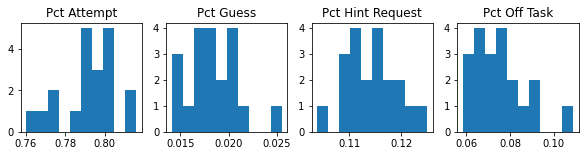

In [31]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [36]:
args = [get_tx_fields, sids, 10]
tx, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

INFO:analytics.cae:Extracted tx for set of students in 2.357335 seconds: (62348, 8)


In [37]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

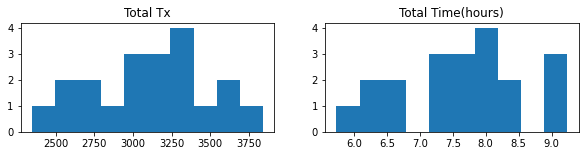

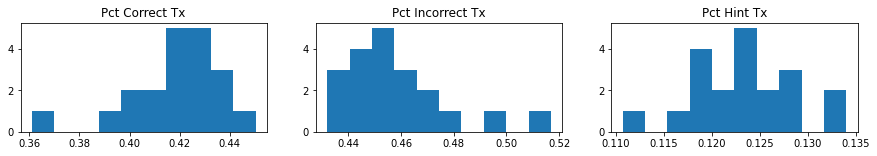

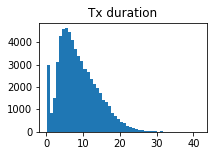

In [38]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

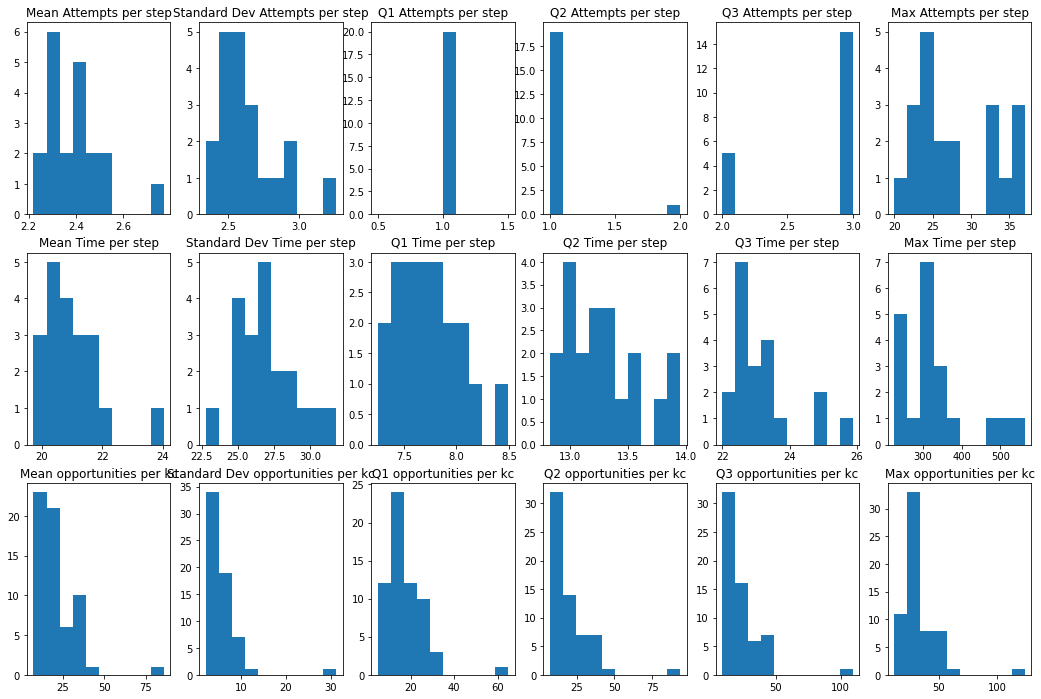

In [39]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


# 2. Test Timed Simulation